In [10]:
## Nature Conservancy Monitoring

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import h5py
import cv2
import os
import glob
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Reshape, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adadelta, Adam, SGD
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, History
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from __future__ import division, print_function
from collections import Counter
%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5105)


In [2]:

% cd /home/hrishi/Desktop/kaggle/fish/input
% rm -r train1
% rm -r valid1
% mkdir train1 valid1
% cp -r train/* train1
% cd train1
# pool_counter = 1

for fish_class in glob.glob('*'): os.mkdir('../valid1/' + fish_class)

rnd_ord = np.random.permutation(glob.glob('*/*.jpg'))
for i in range(500): os.rename(rnd_ord[i], '../valid1/' + rnd_ord[i])

/home/hrishi/Desktop/kaggle/fish/input
/home/hrishi/Desktop/kaggle/fish/input/train1


In [2]:
% cd /home/hrishi/Desktop/kaggle/fish/input
% cd train1

/home/hrishi/Desktop/kaggle/fish/input
/home/hrishi/Desktop/kaggle/fish/input/train1


In [3]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

def VGG_16(size=(224, 224), weights_path='/home/hrishi/Desktop/kaggle/vgg16_bn.h5'):
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,)+size))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model


In [4]:
size = (224, 224)
model = VGG_16(size=size)
model.pop(); model.pop(); model.pop(); model.pop(); model.pop();

for layer in model.layers:
    layer.trainable = False

model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

WARNING (theano.gof.cmodule): WARNING: your Theano flags `gcc.cxxflags` specify an `-march=X` flags.
         It is better to let Theano/g++ find it automatically, but we don't do it now


In [5]:
nb_train_samples = len(glob.glob('*/*.jpg'))
nb_validation_samples = len(glob.glob('../valid1/*/*.jpg'))
nb_epoch = 50
bath_size = 16
nb_test_samples = 1000

classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20.,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        '../train1/',
        target_size=size,
        batch_size=bath_size,
        shuffle = True,
        classes=classes,
        class_mode='categorical')

valid_datagen = ImageDataGenerator()

validation_generator = valid_datagen.flow_from_directory(
        '../valid1/',
        target_size=size,
        batch_size=bath_size,
        shuffle = True,
        classes=classes,
        class_mode='categorical')

callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0)]
#sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer="adadelta", \
              metrics=["accuracy"])

# fine-tune the model
hist = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples,
        callbacks=callbacks)

Found 3277 images belonging to 8 classes.
Found 500 images belonging to 8 classes.
Epoch 1/50
3277/3277 [==============================] - 111s - loss: 1.9468 - acc: 0.4266 - val_loss: 1.0969 - val_acc: 0.6900
Epoch 2/50
3277/3277 [==============================] - 111s - loss: 1.3113 - acc: 0.5862 - val_loss: 0.8829 - val_acc: 0.7680
Epoch 3/50
3277/3277 [==============================] - 111s - loss: 1.1060 - acc: 0.6427 - val_loss: 0.7278 - val_acc: 0.7780
Epoch 4/50
3277/3277 [==============================] - 111s - loss: 0.9806 - acc: 0.6845 - val_loss: 0.6303 - val_acc: 0.8220
Epoch 5/50
3277/3277 [==============================] - 110s - loss: 0.8616 - acc: 0.7110 - val_loss: 0.6754 - val_acc: 0.8240
Epoch 6/50
3277/3277 [==============================] - 111s - loss: 0.8285 - acc: 0.7211 - val_loss: 0.6023 - val_acc: 0.8220
Epoch 7/50
3277/3277 [==============================] - 113s - loss: 0.7864 - acc: 0.7269 - val_loss: 0.6010 - val_acc: 0.8560
Epoch 8/50
3277/3277 [======

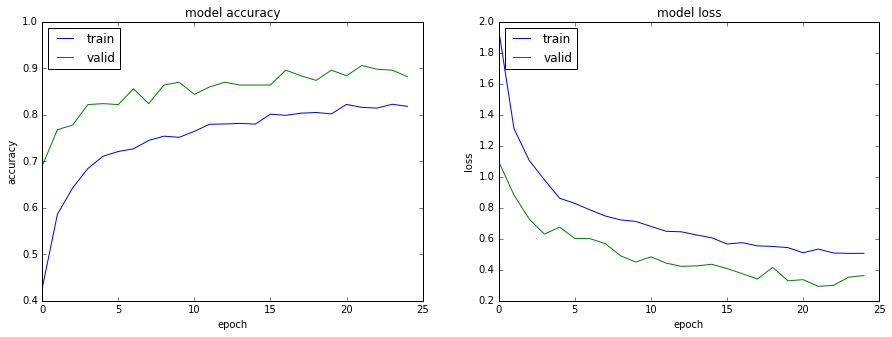

In [6]:

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

In [8]:
model.save_weights('../pickles/vgg16_5_lessdrop.pkl')

In [7]:
test_aug = 5
test_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.1,
        rotation_range=20.,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


for aug in range(test_aug):
    print('Predictions for Augmented -', aug)
    random_seed = np.random.random_integers(0, 100000)

    test_generator = test_datagen.flow_from_directory(
            '../test_stg1/',
            target_size=size,
            batch_size=bath_size,
            shuffle = False,
            seed = random_seed,
            classes = None,
            class_mode = None)

    test_image_list = test_generator.filenames
    if aug == 0:
        predictions = model.predict_generator(test_generator, nb_test_samples)
    else:
        predictions += model.predict_generator(test_generator, nb_test_samples)

predictions /= test_aug

Predictions for Augmented - 0
Found 1000 images belonging to 1 classes.


/home/hrishi/.virtualenvs/cv/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 100000 + 1) instead


Predictions for Augmented - 1
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 2
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 3
Found 1000 images belonging to 1 classes.
Predictions for Augmented - 4
Found 1000 images belonging to 1 classes.


In [8]:
# clip predictions
c = 0
preds = np.clip(predictions, c, 1-c)
pool_counter = 5

print('Begin to write submission file ..')
f_submit = open(os.path.join('/home/hrishi/Desktop/kaggle/fish/input/pooled', \
                             'submit_' + str(pool_counter) +'.csv'), 'w')
f_submit.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
for i, image_name in enumerate(test_generator.filenames):
    pred = ['%.6f' % p for p in preds[i, :]]
    if i%100 == 0:
        print(i, '/', 1000)
    f_submit.write('%s,%s\n' % (os.path.basename(image_name), ','.join(pred)))

f_submit.close()

Begin to write submission file ..
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
